In [1]:
import tensorflow as tf
import h5py
import ml_dtypes
print(f"TensorFlow Version: {tf.__version__}")
print(f"h5py Version: {h5py.__version__}")
print(f"ml_dtypes Version: {ml_dtypes.__version__}")
import warnings
warnings.filterwarnings("ignore", message=".*LOKY_MAX_CPU_COUNT.*")



TensorFlow Version: 2.18.0
h5py Version: 3.13.0
ml_dtypes Version: 0.4.1


In [2]:
import os
import tensorboard as tb
print(tb.__file__)


C:\Users\l_alm\miniconda3\envs\pytorch_env\lib\site-packages\tensorboard\__init__.py


In [25]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
import torch
import scipy.io
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from collections import Counter
from torch.profiler import profile, ProfilerActivity
from torch import nn, optim
from torch.utils.data import DataLoader
from imblearn.over_sampling import SMOTE
from torchinfo import summary  #for model summary
import tensorflow as tf
import tempfile
import os
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
########################################################################
def compute_flops_tf(model, input_shape, batch_size=128, mode='test'):

    @tf.function
    def forward_pass(inputs):
        return model(inputs)

    @tf.function
    def train_step(inputs, targets):
        with tf.GradientTape() as tape:
            predictions = model(inputs)
            loss = tf.keras.losses.sparse_categorical_crossentropy(targets, predictions)
        gradients = tape.gradient(loss, model.trainable_variables)
        return predictions, gradients

    #function based on mode
    if mode == 'train':
        concrete_func = train_step.get_concrete_function(
            tf.TensorSpec([batch_size] + list(input_shape), tf.float32),
            tf.TensorSpec([batch_size], tf.int32)
        )
    else:  #if testing
        concrete_func = forward_pass.get_concrete_function(
            tf.TensorSpec([batch_size] + list(input_shape), tf.float32)
        )

    # converting variables to constants for profiling
    frozen_func = convert_variables_to_constants_v2(concrete_func)
    graph_def = frozen_func.graph.as_graph_def()

    with tf.Graph().as_default() as graph:
        tf.graph_util.import_graph_def(graph_def, name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(
            graph=graph, run_meta=run_meta, cmd='op', options=opts
        )

    return flops.total_float_ops/ 1e9  # G

##################################################################3


from torch.utils.data import Dataset, DataLoader


class MyDataset(Dataset):
    def __init__(self, data, label):
        self.data = data
        self.label = label

    def __getitem__(self, index):
        return (torch.tensor(self.data[index], dtype=torch.float), torch.tensor(self.label[index], dtype=torch.long))

    def __len__(self):
        return len(self.data)
        
#load and preprocess data
data = r'C:\Users\l_alm\resnet1d-master\content\customerTargeting.csv'
df = pd.read_csv(data)
X = df.drop(columns=["target"])
y=df["target"]

# 80% (train + validation) and 20% (test)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 60% (train) and 20% (validation) from the 80% data
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)


#the final sizes
print(f"Train: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")

training_size=len(X_train)+len(X_val)
testing_size=len(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_reshaped = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))




Train: 3972, Validation: 1324, Test: 1324


In [26]:
# ResNet models for Keras.
# Reference for ResNets - [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf))
def Conv_1D_Block(x, model_width, kernel, strides):
    # 1D Convolutional Block with BatchNormalization
    x = tf.keras.layers.Conv1D(model_width, kernel, strides=strides, padding="same", kernel_initializer="he_normal")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    return x


def stem(inputs, num_filters):
    # Construct the Stem Convolution Group
    # inputs : input vector
    # First Convolutional layer, where pooled feature maps will be reduced by 75%
    conv = Conv_1D_Block(inputs, num_filters, 7, 2)
    if conv.shape[1] <= 2:
        pool = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(conv)
    else:
        pool = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(conv)
    
    return pool


def conv_block(inputs, num_filters):
    # Construct Block of Convolutions without Pooling
    # x        : input into the block
    # n_filters: number of filters
    conv = Conv_1D_Block(inputs, num_filters, 3, 2)
    conv = Conv_1D_Block(conv, num_filters, 3, 1)
    
    return conv


def residual_block(inputs, num_filters):
    # Construct a Residual Block of Convolutions
    # x        : input into the block
    # n_filters: number of filters
    shortcut = inputs
    #
    conv = Conv_1D_Block(inputs, num_filters, 3, 1)
    conv = Conv_1D_Block(conv, num_filters, 3, 1)
    conv = tf.keras.layers.Add()([conv, shortcut])
    out = tf.keras.layers.Activation('relu')(conv)
    
    return out


def residual_group(inputs, num_filters, n_blocks, conv=True):
    # x        : input to the group
    # n_filters: number of filters
    # n_blocks : number of blocks in the group
    # conv     : flag to include the convolution block connector
    out = inputs
    for i in range(n_blocks):
        out = residual_block(out, num_filters)

    # Double the size of filters and reduce feature maps by 75% (strides=2, 2) to fit the next Residual Group
    if conv:
        out = conv_block(out, num_filters * 2)
    
    return out


def stem_bottleneck(inputs, num_filters):
    # Construct the Stem Convolution Group
    # inputs :input vector
    # First Convolutional layer, where pooled feature maps will be reduced by 75%
    conv = Conv_1D_Block(inputs, num_filters, 7, 2)
    if conv.shape[1] <= 2:
        pool = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(conv)
    else:
        pool = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(conv)
    
    return pool


def residual_block_bottleneck(inputs, num_filters):
    # Construct a Residual Block of Convolutions
    # x        : input into the block
    # n_filters: number of filters
    shortcut = Conv_1D_Block(inputs, num_filters * 4, 1, 1)
    #
    conv = Conv_1D_Block(inputs, num_filters, 1, 1)
    conv = Conv_1D_Block(conv, num_filters, 3, 1)
    conv = Conv_1D_Block(conv, num_filters * 4, 1, 1)
    conv = tf.keras.layers.Add()([conv, shortcut])
    out = tf.keras.layers.Activation('relu')(conv)

    return out


def residual_group_bottleneck(inputs, num_filters, n_blocks, conv=True):
    # x        : input to the group
    # n_filters: number of filters
    # n_blocks : number of blocks in the group
    # conv     : flag to include the convolution block connector
    out = inputs
    for i in range(n_blocks):
        out = residual_block_bottleneck(out, num_filters)

    # Double the size of filters and reduce feature maps by 75% (strides=2, 2) to fit the next Residual Group
    if conv:
        out = conv_block(out, num_filters * 2)

    return out


def learner18(inputs, num_filters):
    # Construct the Learner
    x = residual_group(inputs, num_filters, 2)          # First Residual Block Group of 64 filters
    x = residual_group(x, num_filters * 2, 1)           # Second Residual Block Group of 128 filters
    x = residual_group(x, num_filters * 4, 1)           # Third Residual Block Group of 256 filters
    out = residual_group(x, num_filters * 8, 1, False)  # Fourth Residual Block Group of 512 filters
    
    return out


def learner34(inputs, num_filters):
    # Construct the Learner
    x = residual_group(inputs, num_filters, 3)          # First Residual Block Group of 64 filters
    x = residual_group(x, num_filters * 2, 3)           # Second Residual Block Group of 128 filters
    x = residual_group(x, num_filters * 4, 5)           # Third Residual Block Group of 256 filters
    out = residual_group(x, num_filters * 8, 2, False)  # Fourth Residual Block Group of 512 filters
    
    return out


def learner50(inputs, num_filters):
    # Construct the Learner
    x = residual_group_bottleneck(inputs, num_filters, 3)  # First Residual Block Group of 64 filters
    x = residual_group_bottleneck(x, num_filters * 2, 3)   # Second Residual Block Group of 128 filters
    x = residual_group_bottleneck(x, num_filters * 4, 5)   # Third Residual Block Group of 256 filters
    out = residual_group_bottleneck(x, num_filters * 8, 2, False)  # Fourth Residual Block Group of 512 filters
    
    return out


def learner101(inputs, num_filters):
    # Construct the Learner
    x = residual_group_bottleneck(inputs, num_filters, 3)  # First Residual Block Group of 64 filters
    x = residual_group_bottleneck(x, num_filters * 2, 3)   # Second Residual Block Group of 128 filters
    x = residual_group_bottleneck(x, num_filters * 4, 22)  # Third Residual Block Group of 256 filters
    out = residual_group_bottleneck(x, num_filters * 8, 2, False)  # Fourth Residual Block Group of 512 filters
    
    return out


def learner152(inputs, num_filters):
    # Construct the Learner
    x = residual_group_bottleneck(inputs, num_filters, 3)  # First Residual Block Group of 64 filters
    x = residual_group_bottleneck(x, num_filters * 2, 7)   # Second Residual Block Group of 128 filters
    x = residual_group_bottleneck(x, num_filters * 4, 35)  # Third Residual Block Group of 256 filters
    out = residual_group_bottleneck(x, num_filters * 8, 2, False)  # Fourth Residual Block Group of 512 filters
    
    return out


def classifier(inputs, class_number):
    # Construct the Classifier Group
    # inputs       : input vector
    # class_number : number of output classes
    out = tf.keras.layers.Dense(class_number, activation='softmax')(inputs)
    
    return out


def regressor(inputs, feature_number):
    # Construct the Regressor Group
    # inputs       : input vector
    # feature_number : number of output features
    out = tf.keras.layers.Dense(feature_number, activation='linear')(inputs)
    
    return out


class ResNet:
    def __init__(self, length, num_channel, num_filters, problem_type='Regression',
                 output_nums=1, pooling='avg', dropout_rate=False):
        self.length = length
        self.num_channel = num_channel
        self.num_filters = num_filters
        self.problem_type = problem_type
        self.output_nums = output_nums
        self.pooling = pooling
        self.dropout_rate = dropout_rate

    def MLP(self, x):
        if self.pooling == 'avg':
            x = tf.keras.layers.GlobalAveragePooling1D()(x)
        elif self.pooling == 'max':
            x = tf.keras.layers.GlobalMaxPooling1D()(x)
        # Final Dense Outputting Layer for the outputs
        x = tf.keras.layers.Flatten(name='flatten')(x)
        if self.dropout_rate:
            x = tf.keras.layers.Dropout(self.dropout_rate, name='Dropout')(x)
        outputs = tf.keras.layers.Dense(self.output_nums, activation='linear')(x)
        if self.problem_type == 'Classification':
            outputs = tf.keras.layers.Dense(self.output_nums, activation='softmax')(x)

        return outputs

    def ResNet18(self):
        inputs = tf.keras.Input((self.length, self.num_channel))      # The input tensor
        stem_ = stem(inputs, self.num_filters)               # The Stem Convolution Group
        x = learner18(stem_, self.num_filters)               # The learner
        outputs = self.MLP(x)
        # Instantiate the Model
        model = tf.keras.Model(inputs, outputs)

        return model

    def ResNet34(self):
        inputs = tf.keras.Input((self.length, self.num_channel))      # The input tensor
        stem_ = stem(inputs, self.num_filters)               # The Stem Convolution Group
        x = learner34(stem_, self.num_filters)               # The learner
        outputs = self.MLP(x)
        # Instantiate the Model
        model = tf.keras.Model(inputs, outputs)

        return model

    def ResNet50(self):
        inputs = tf.keras.Input((self.length, self.num_channel))     # The input tensor
        stem_b = stem_bottleneck(inputs, self.num_filters)  # The Stem Convolution Group
        x = learner50(stem_b, self.num_filters)             # The learner
        outputs = self.MLP(x)
        # Instantiate the Model
        model = tf.keras.Model(inputs, outputs)

        return model

    def ResNet101(self):
        inputs = tf.keras.Input((self.length, self.num_channel))     # The input tensor
        stem_b = stem_bottleneck(inputs, self.num_filters)  # The Stem Convolution Group
        x = learner101(stem_b, self.num_filters)            # The learner
        outputs = self.MLP(x)
        # Instantiate the Model
        model = tf.keras.Model(inputs, outputs)

        return model

    def ResNet152(self):
        inputs = tf.keras.Input((self.length, self.num_channel))     # The input tensor
        stem_b = stem_bottleneck(inputs, self.num_filters)  # The Stem Convolution Group
        x = learner152(stem_b, self.num_filters)            # The learner
        outputs = self.MLP(x)
        # Instantiate the Model
        model = tf.keras.Model(inputs, outputs)

        return model


 

# Defining the model and computing flops

In [27]:
if __name__ == '__main__':
    # Configurations
    length = 70  # Length of each Segment
    model_name = 'ResNet34'  
    model_width = 16 # Width of the Initial Layer, subsequent layers start from here
    num_channel = 1  # Number of Input Channels in the Model
    problem_type = 'Classification' # Classification or Regression
    output_nums = 3  # Number of Class for Classification Problems, always '1' for Regression Problems

In [28]:
model = ResNet(length, num_channel, model_width, problem_type=problem_type, output_nums=output_nums, pooling='avg', dropout_rate=False).ResNet34()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',    metrics=['accuracy'])
model.summary()
###########################################################
input_shape = (70, 1)  #the datasets input shape for resnet
num_classes = 3
batch_size = 128
flops_test = compute_flops_tf(model, input_shape, batch_size=batch_size, mode='test')*testing_size
flops_train = compute_flops_tf(model, input_shape, batch_size=batch_size, mode='train')*training_size

print(f"Estimated FLOPs for batch size {batch_size} (Testing - Inference): {flops_test:.6f} G")
print(f"Estimated FLOPs for batch size {batch_size} (Training - Forward + Backward): {flops_train:.6f} G")
##########################################################

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 70, 1)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_99 (Conv1D)            │ (None, 35, 16)            │             128 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_99        │ (None, 35, 16)            │              64 │ conv1d_99[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_138 (Activation)   │ (None, 35, 16)            │               0 │ batch_normalization_99[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_3               │ (None, 17, 16)            │               0 │ activation_138[0][0]       │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_100 (Conv1D)           │ (None, 17, 16)            │             784 │ max_pooling1d_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_100       │ (None, 17, 16)            │              64 │ conv1d_100[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_139 (Activation)   │ (None, 17, 16)            │               0 │ batch_normalization_100[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_101 (Conv1D)           │ (None, 17, 16)            │             784 │ activation_139[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_101       │ (None, 17, 16)            │              64 │ conv1d_101[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_140 (Activation)   │ (None, 17, 16)            │               0 │ batch_normalization_101[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_39 (Add)                  │ (None, 17, 16)            │               0 │ activation_140[0][0],      │
│                               │                           │                 │ max_pooling1d_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_141 (Activation)   │ (None, 17, 16)            │               0 │ add_39[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_102 (Conv1D)           │ (None, 17, 16)            │             784 │ activation_141[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_102       │ (None, 17, 16)            │              6

 Total params: 449,315 (1.71 MB)

 Trainable params: 445,507 (1.70 MB)

 Non-trainable params: 3,808 (14.88 KB)

Estimated FLOPs for batch size 128 (Testing - Inference): 618.935343 G
Estimated FLOPs for batch size 128 (Training - Forward + Backward): 7367.644778 G


# Training the model

In [22]:

classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = {i: weights[i] for i in range(len(classes))}
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=64, shuffle =True, class_weight=class_weights, callbacks=[early_stop]
    
)




Epoch 1/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 48s 67ms/step - accuracy: 0.4031 - loss: 1.1740 - val_accuracy: 0.4872 - val_loss: 1.9900
Epoch 2/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.5328 - loss: 0.9755 - val_accuracy: 0.4789 - val_loss: 1.1789
Epoch 3/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.6055 - loss: 0.8701 - val_accuracy: 0.5144 - val_loss: 1.1600
Epoch 4/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.6554 - loss: 0.8058 - val_accuracy: 0.4600 - val_loss: 1.1695
Epoch 5/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.6979 - loss: 0.7213 - val_accuracy: 0.4524 - val_loss: 1.2512


# Testing

In [29]:
model.evaluate(X_test, y_test)

y_pred = np.argmax(model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred, digits=4))

42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4309 - loss: 205.5657 
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       328
           1     0.4562    1.0000    0.6266       604
           2     0.0000    0.0000    0.0000       392

    accuracy                         0.4562      1324
   macro avg     0.1521    0.3333    0.2089      1324
weighted avg     0.2081    0.4562    0.2858      1324



C:\Users\l_alm\miniconda3\envs\pytorch_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\l_alm\miniconda3\envs\pytorch_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\l_alm\miniconda3\envs\pytorch_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

# plotting loss

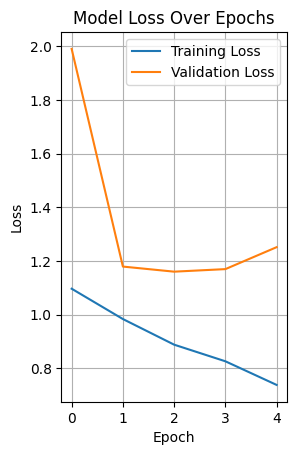

In [24]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


plt.show()